<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap

**2. Load and Inspect the Dataset**

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load clusterd dataset
data = pd.read_csv('/content/drive/MyDrive/DSGP/New/new_target_dataset.csv')

In [4]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64653 entries, 0 to 64652
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Gender                       64653 non-null  int64 
 1   Continent                    64653 non-null  int64 
 2   Age_group                    64653 non-null  int64 
 3   Socioeconomic_Status_High    64653 non-null  bool  
 4   Socioeconomic_Status_Low     64653 non-null  bool  
 5   Socioeconomic_Status_Middle  64653 non-null  bool  
 6   Tobacco_Use_No               64653 non-null  bool  
 7   Tobacco_Use_Yes              64653 non-null  bool  
 8   Alcohol_Use_No               64653 non-null  bool  
 9   Alcohol_Use_Yes              64653 non-null  bool  
 10  HPV_Related_No               64653 non-null  bool  
 11  HPV_Related_Yes              64653 non-null  bool  
 12  Risk_Level                   64653 non-null  object
dtypes: bool(9), int64

In [5]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   Gender  Continent  Age_group  Socioeconomic_Status_High  \
0       0          4          0                       True   
1       1          0          2                       True   
2       1          0          2                      False   
3       0          4          1                      False   
4       0          0          0                      False   

   Socioeconomic_Status_Low  Socioeconomic_Status_Middle  Tobacco_Use_No  \
0                     False                        False           False   
1                     False                        False           False   
2                     False                         True           False   
3                     False                         True           False   
4                     False                         True           False   

   Tobacco_Use_Yes  Alcohol_Use_No  Alcohol_Use_Yes  HPV_Related_No  \
0             True           False             True            True   
1            

In [6]:
# View the shape of dataset
print("\nDataset Shape:")
print(data.shape)


Dataset Shape:
(64653, 13)


**3.Encoded Risk Levels and Defined Target Variable**

In [7]:
# Manually map risk levels
risk_mapping = {
    'Low Risk': 0,
    'Medium Risk': 1,
    'High Risk': 2
}

#Add mapping to the Risk_Level column
data['Risk_Level'] = data['Risk_Level'].map(risk_mapping)

# Define target variable y
y = data['Risk_Level']

print(y.value_counts())

Risk_Level
1    25564
2    24394
0    14695
Name: count, dtype: int64


In [8]:
data.head(10)

,Gender,Continent,Age_group,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes,Risk_Level
0,0,4,0,True,False,False,False,True,False,True,True,False,0
1,1,0,2,True,False,False,False,True,False,True,True,False,0
2,1,0,2,False,False,True,False,True,False,True,False,True,2
3,0,4,1,False,False,True,False,True,False,True,True,False,0
4,0,0,0,False,False,True,False,True,False,True,True,False,0
5,0,1,0,True,False,False,False,True,True,False,True,False,0
6,1,2,0,False,True,False,False,True,False,True,True,False,1
7,1,1,2,False,True,False,False,True,False,True,False,True,2
8,1,4,1,False,True,False,True,False,True,False,True,False,2
9,1,2,1,False,False,True,True,False,False,True,True,False,1


**4.Visualize Relationship Between features and the target variable**

Correlations with Target Column:
Gender                         0.018166
Continent                     -0.000474
Age_group                     -0.023755
Socioeconomic_Status_High     -0.108115
Socioeconomic_Status_Low       0.190708
Socioeconomic_Status_Middle   -0.099864
Tobacco_Use_No                 0.456385
Tobacco_Use_Yes               -0.456385
Alcohol_Use_No                -0.136119
Alcohol_Use_Yes                0.136119
HPV_Related_No                -0.361729
HPV_Related_Yes                0.361729
Name: Risk_Level, dtype: float64


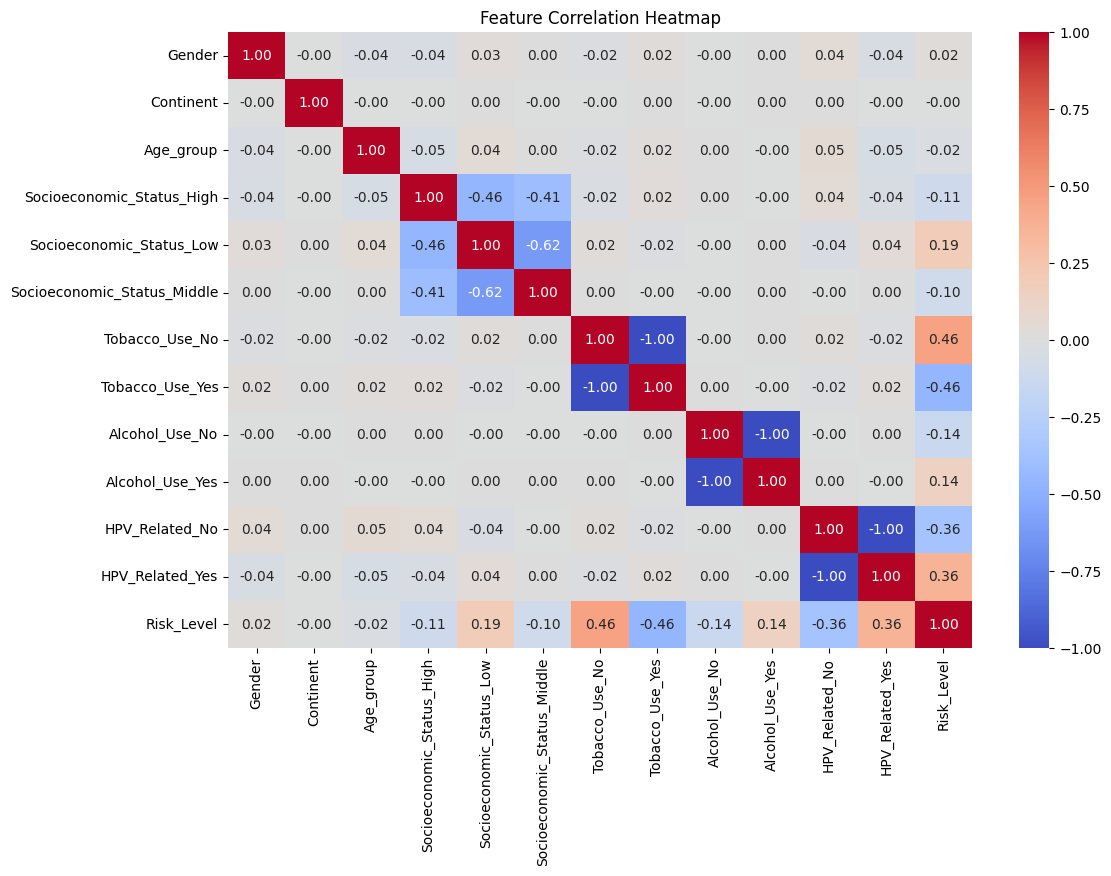

In [9]:
# Define target variable
target_column = 'Risk_Level'

# Calculate correlations with target variable
correlations = data.corr()[target_column].drop(target_column)

# Print correlations
print("Correlations with Target Column:")
print(correlations)

# Heatmap visualization of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**5. Feature Selection**

**Based on the correlation analysis and domain knowledge, drop features that have low correlation with the target variable and redundant variables due to one-hot encoding of binary categories.

In [10]:
# Drop low-correlation and redundant features
data = data.drop(columns=[ 'Continent', 'Tobacco_Use_No', 'Alcohol_Use_No', 'HPV_Related_No', 'Socioeconomic_Status_High'])

In [11]:
# Print remaining features
print("\nRemaining features :")
print(list(data.columns))


Remaining features :
['Gender', 'Age_group', 'Socioeconomic_Status_Low', 'Socioeconomic_Status_Middle', 'Tobacco_Use_Yes', 'Alcohol_Use_Yes', 'HPV_Related_Yes', 'Risk_Level']


In [12]:
#Save feature_names
import pickle
with open('/content/drive/MyDrive/DSGP/New/feature_names.pkl', 'wb') as file:
    pickle.dump(list(data.columns), file)

**6. Train-Test Split**

In [13]:
#Separate Features and Target Variable
X = data.drop('Risk_Level', axis=1)
y = data['Risk_Level']

#Perform Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

#Save training set
with open('/content/drive/MyDrive/DSGP/New/X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

Training set size: 51722
Test set size: 12931


**7. Feature Scaling**

In [14]:
#Applied Standard Scaling to Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('/content/drive/MyDrive/DSGP/New/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('/content/drive/MyDrive/DSGP/New/X_train_scaled.pkl', 'wb') as file:
    pickle.dump(X_train_scaled, file)

**8. Train Decision Tree Classifier**


Cross-Validation Accuracy: 0.8183 ± 0.0255

Training Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.89      1.00      0.94     11737
 Medium Risk       0.82      0.88      0.85     20444
   High Risk       0.86      0.72      0.78     19541

    accuracy                           0.85     51722
   macro avg       0.86      0.87      0.86     51722
weighted avg       0.85      0.85      0.85     51722


Testing Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.88      1.00      0.94      2958
 Medium Risk       0.82      0.88      0.85      5120
   High Risk       0.85      0.71      0.78      4853

    accuracy                           0.85     12931
   macro avg       0.85      0.87      0.86     12931
weighted avg       0.85      0.85      0.84     12931



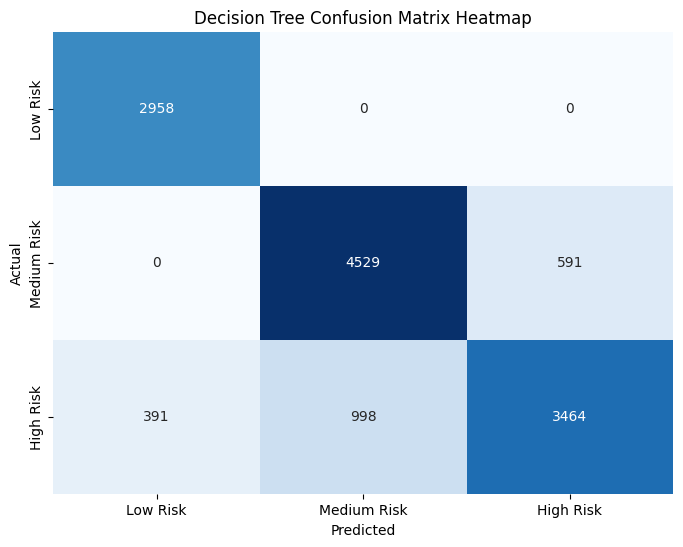

In [16]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

# Cross-validation with accuracy scoring
cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train model on scaled training data
dt_model.fit(X_train_scaled, y_train)

# Predictions on training and testing data
y_train_pred = dt_model.predict(X_train_scaled)
y_test_pred = dt_model.predict(X_test_scaled)

# Define target names
target_names = ['Low Risk', 'Medium Risk', 'High Risk']

# Classification Report for training data
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred,target_names=target_names))

# Classification Report for testing data
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred,target_names=target_names))

# Confusion matrix for testing data
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix Heatmap')
plt.show()

with open('/content/drive/MyDrive/DSGP/New/Decision_Tree_Classifier.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

**9.Train Random Forest Classifier**


Cross-Validation Accuracy: 0.9703 ± 0.0023

Random Forest Classifier Training Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.89      1.00      0.94     11737
 Medium Risk       1.00      1.00      1.00     20444
   High Risk       1.00      0.92      0.96     19541

    accuracy                           0.97     51722
   macro avg       0.96      0.97      0.97     51722
weighted avg       0.97      0.97      0.97     51722


Random Forest Classifier Testing Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.88      1.00      0.94      2958
 Medium Risk       1.00      1.00      1.00      5120
   High Risk       1.00      0.92      0.96      4853

    accuracy                           0.97     12931
   macro avg       0.96      0.97      0.97     12931
weighted avg       0.97      0.97      0.97     12931



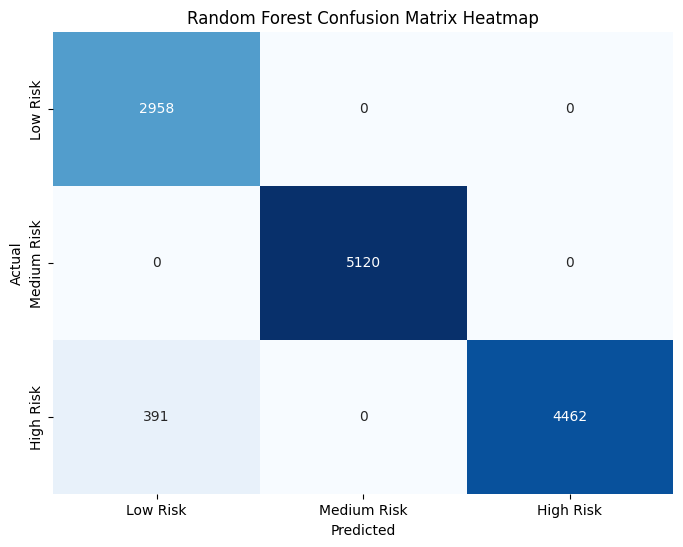

In [17]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

# Cross-validation with accuracy scoring
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train model on scaled training data
rf_model.fit(X_train_scaled, y_train)

# Predictions on training and testing data
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Classification Report for training data
print("\nRandom Forest Classifier Training Classification Report:")
print(classification_report(y_train, y_train_pred,target_names=target_names))

# Classification Report for testing data
print("\nRandom Forest Classifier Testing Classification Report:")
print(classification_report(y_test, y_test_pred,target_names=target_names))

# Confusion matrix for testing data
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix Heatmap')
plt.show()

with open('/content/drive/MyDrive/DSGP/New/Random_Forest_Classifier.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

**10. XAI- SHAP For RF Model**

*   This used for model interpretation and understanding feature importance in the trained Random Forest Classifier
*   This computes and visualizes the mean SHAP values for each feature across different oral cancer risk classes (Low, Medium, High) using a trained Random Forest model. It highlights the most influential features per class in a bar chart, helping interpret model predictions globally.



**11. SHAP Global Summary Report for Oral Cancer Risk Prediction**

In [18]:
with open("/content/drive/MyDrive/DSGP/New/siyumi/Random_Forest_Classifier.pkl", "rb") as f:
    rf_model = pickle.load(f)

with open("/content/drive/MyDrive/DSGP/New/siyumi/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("/content/drive/MyDrive/DSGP/New/siyumi/feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

with open("/content/drive/MyDrive/DSGP/New/siyumi/X_train_scaled.pkl", "rb") as f:
    X_train_scaled = pickle.load(f)

# Get SHAP values for the trained Random Forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_scaled)

print(np.shape(shap_values))

(51722, 7, 3)


**12. SHAP Mean Plot by Class**

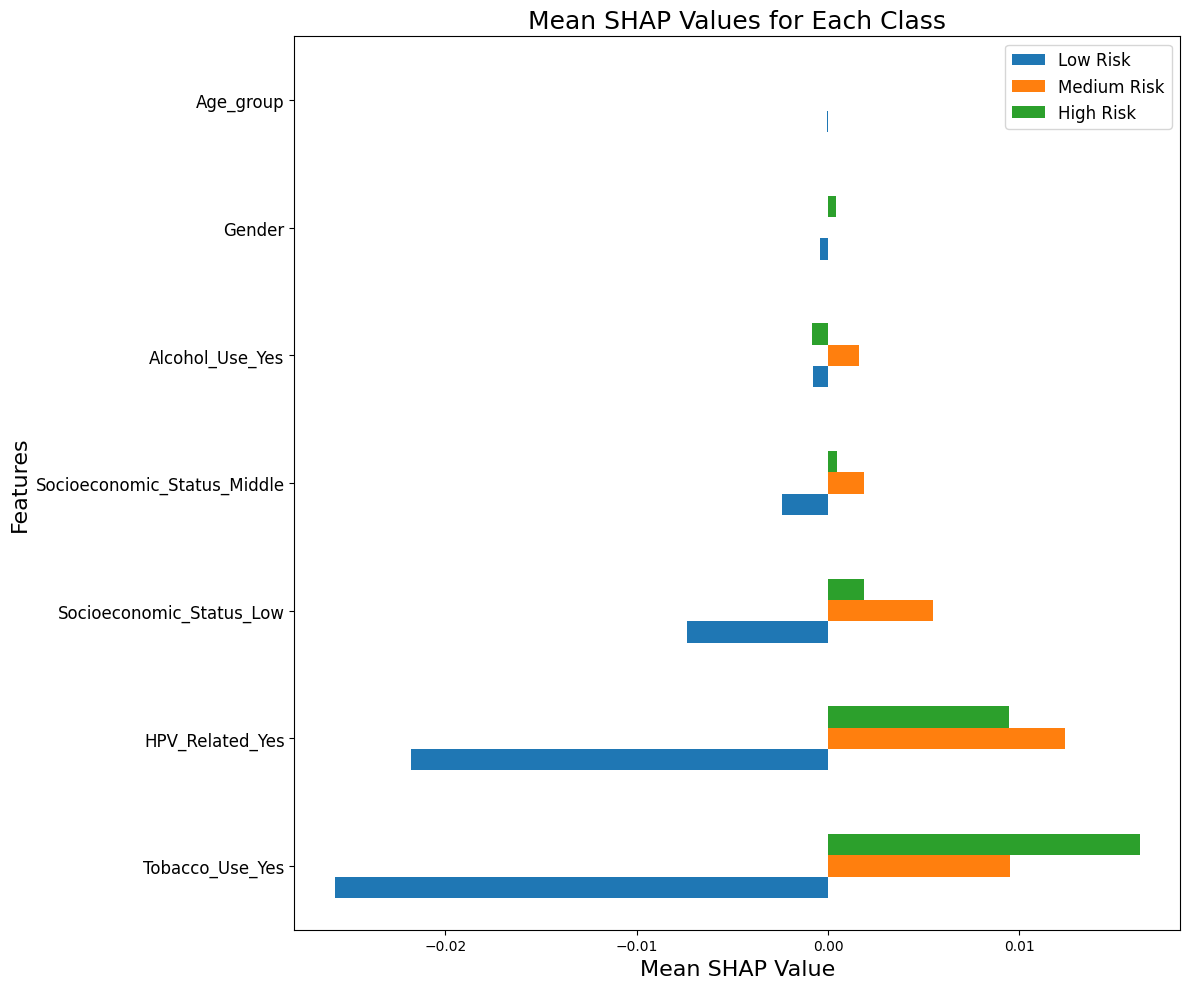

In [19]:
# Remove target column in feature names file
if "Risk_Level" in feature_names:
    feature_names.remove("Risk_Level")

# Calculate mean SHAP values per class
mean_shap_values = np.mean(shap_values, axis=0)

# Combine class-wise mean SHAPs into DataFrame
data = pd.DataFrame(
    mean_shap_values,
    index=feature_names,
    columns=["Low Risk", "Medium Risk", "High Risk"]
)

# Sort features by total importance
feature_importance = np.abs(mean_shap_values).sum(axis=1)
data_sorted = data.iloc[np.argsort(-feature_importance)]

# Plot horizontal bar chart of SHAP importance
fig, ax = plt.subplots(figsize=(12, 10))
data_sorted.plot.barh(ax=ax)

ax.set_xlabel("Mean SHAP Value", size=16)
ax.set_ylabel("Features", size=16)
ax.set_title("Mean SHAP Values for Each Class", size=18)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()